### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 15th at 11.59pm CST
---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import scipy.optimize as opt
import scipy.integrate as inte
import corner
%config InlineBackend.figure_format='retina'

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3.5 to 6.5. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to $\mu+\sigma_\mathrm{mean}$ and $\mu-\sigma_\mathrm{mean}$. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.5 to 5.5. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6.1\pm0.25$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6.1$ with standard deviation of $0.25$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [73]:
#1 We have to load in the file and then calculate the mean and stdev
data = np.load("hw4_data_1.npy")
print(data) #print to ensure accuracy

[[4.36 2.24]
 [4.   1.94]
 [4.87 1.39]
 [5.64 2.55]
 [6.14 1.69]
 [5.92 1.38]
 [3.93 1.  ]
 [6.58 1.6 ]
 [3.78 1.  ]
 [5.84 1.  ]]


In [74]:
#use variable names to represent the array slices that we want
measurements = data[:,0]
sigmas = data[:,1]
weights = sigmas**-2

In [75]:
# Using formulas above we can calculate mean and standard deviation
sample_mean = np.sum(weights*measurements) / np.sum(weights)
standard_error = (np.sum(weights))**-0.5
print("Analytic Mean is: ",sample_mean)
print("Standard Error is: ",standard_error)

Analytic Mean is:  4.942118214425305
Standard Error is:  0.4302433460520509


In [76]:
#2 Using the log-likelihood function for gaussian with varied sigmas
def logLikelihood(xi,mu,sigma):
    return np.sum((xi - mu)**2 / (2 * sigma**2))

gunga = lambda mu_test : logLikelihood(measurements,mu_test,sigmas)
mu_guess = 10

optimal_mu = opt.fsolve(gunga,mu_guess)
print("MLE mean is: ",optimal_mu[0])

MLE mean is:  4.941926406502054


/tmp/ipykernel_41395/1688197281.py:8: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  optimal_mu = opt.fsolve(gunga,mu_guess)


SRT: This is the correct form of the chi-squared portion of the log likelihood, but the normalization factor is missing. You get the correct answer here, but note that you may run into problems later without the normalization. -1 point

In [77]:
#3 We need to first define the prior as a uniform distribution from 3.5 - 6.5 and the Likelihood function
def prior_uniform(mu):
    if mu >= 3.5 and mu <= 6.5:
        return 1 / 3
    else:
        return 0
        
def Likelihood(measures,mu,sigmas):
    return np.prod(1/(np.sqrt(np.pi)*sigmas)*np.exp(-(measures-mu)**2/(2*sigmas**2)))

In [78]:
def Bayseian(prior_function,Likelihood):
    
    mu_trials = np.linspace(0,10,10000)

    #Create a prior distribution from mu values
    prior_dist = np.array([prior_function(mu) for mu in mu_trials])

    #sanity check to make sure normalization
    integral_prior = np.trapz(prior_dist,mu_trials)
    
    #Calculate posterior using Likelihood * prior
    posterior = np.array([Likelihood(measurements,mu,sigmas) * prior_function(mu) for mu in mu_trials])

    #Integrate the total posterior over all mu to get the evidence
    evidence = np.trapz(posterior,mu_trials)

    #Normalize the posterior using the evidence
    normalized_posterior = posterior / evidence
    
    #sanity check to make sure normalization
    integral_nomralized_posterior = np.trapz(normalized_posterior,mu_trials)
    
    #Create a cdf from this pdf
    CDF = np.array([np.trapz(normalized_posterior[:i],mu_trials[:i]) for i in range(len(mu_trials))])
    
    #find value of 68.3/2 of each side of the cdf
    lower_index = 0
    upper_index = 0
    
    for i in range(1,len(CDF) - 1):
        if CDF[i] >= .683/2:
            lower_index = i
            break
            
    for i in range(len(CDF) - 1,0,-1):
        if CDF[i] <= 1 - .683/2:
            upper_index = i
            break
    
    #Calculate the MAP
    arguments = np.argsort(normalized_posterior)
    MAP = mu_trials[arguments[-1]]
    
    plt.plot(mu_trials,normalized_posterior)
    plt.plot(mu_trials[arguments[-1]],normalized_posterior[arguments[-1]],'rD')
    plt.xlim(3.4,6.6)
    plt.xlabel(r"$\mu$")
    plt.show()
    

    print("Integral of prior distribution is: ",integral_prior)
    print("Integral of normalized posterior distribution is: ", integral_nomralized_posterior)
    print("Lower bound of cofidence is: ", mu_trials[lower_index], " Upper bound of cofidence is: ", mu_trials[upper_index])
    print("From MLE Lower bound is: ", sample_mean - standard_error, "Upper bound is:", sample_mean + standard_error)
    
    print("MAP: ", MAP)
    print("MLE mean: ", sample_mean)
    return normalized_posterior, evidence

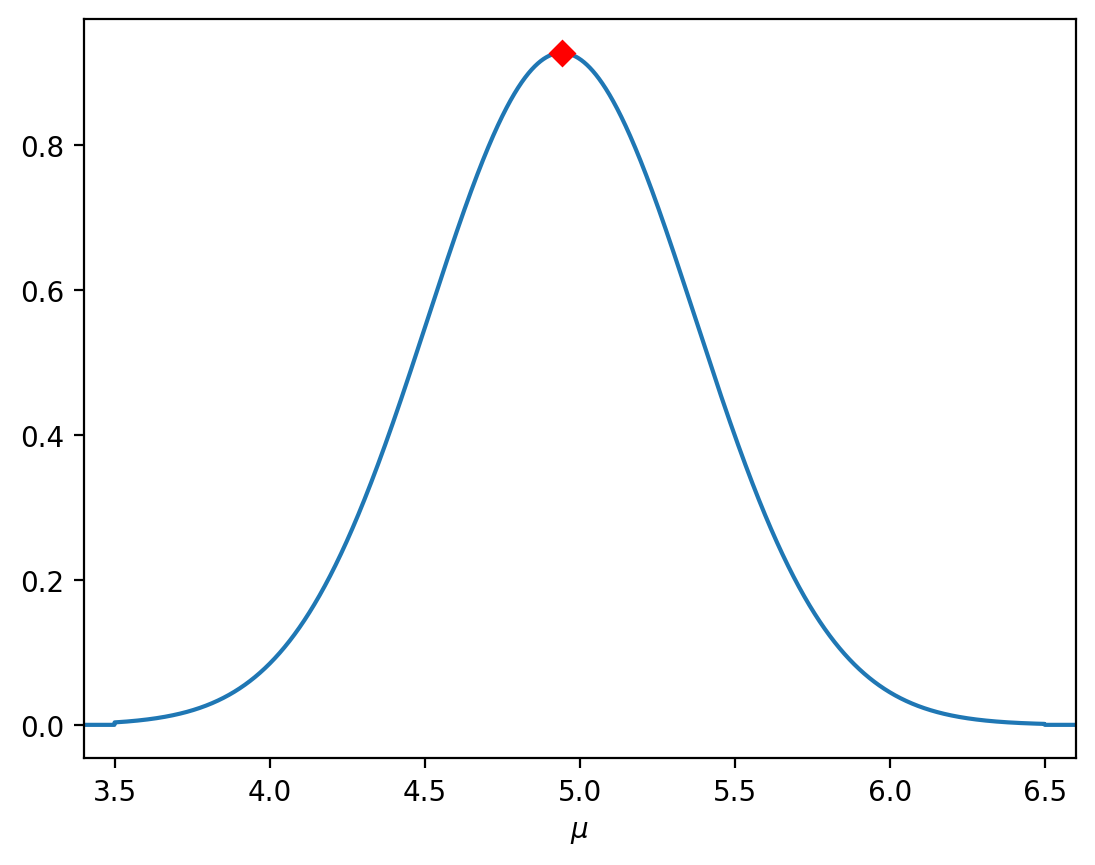

Integral of prior distribution is:  1.000100010001
Integral of normalized posterior distribution is:  1.0
Lower bound of cofidence is:  4.768476847684768  Upper bound of cofidence is:  5.118511851185119
From MLE Lower bound is:  4.511874868373254 Upper bound is: 5.372361560477356
MAP:  4.942494249424943
MLE mean:  4.942118214425305


In [79]:
np1, e1 = Bayseian(prior_uniform,Likelihood)

SRT: Your MLE bounds, MAP, and MLE mean all look fine. But something seems to have gone awry in your CDF calculation. Maybe related to the finiteness of your integration grid? -2 points

In [ ]:
# Try the following instead
#(4)
post = np.exp(logp_uniform) / np.sum(np.exp(logp_uniform)) / np.diff(mu_proposed)[0]
post_dist = scipy.stats.rv_histogram((post,mu_proposed))
lower = post_dist.ppf(0.16)
upper = post_dist.ppf(0.84)

print('Bayesian = ', lower, upper)
print('Standard fitting = ', mle_mean-mle_mean_err, mle_mean+mle_mean_err)
print('MAP value = ', mu_mid[np.argmax(post)])

In [80]:
#4 Define our new prior
def prior_uniform_2(mu):
    if mu >= 4.5 and mu <= 5.5:
        return 1 / (5.5-4.5)
    else:
        return 0

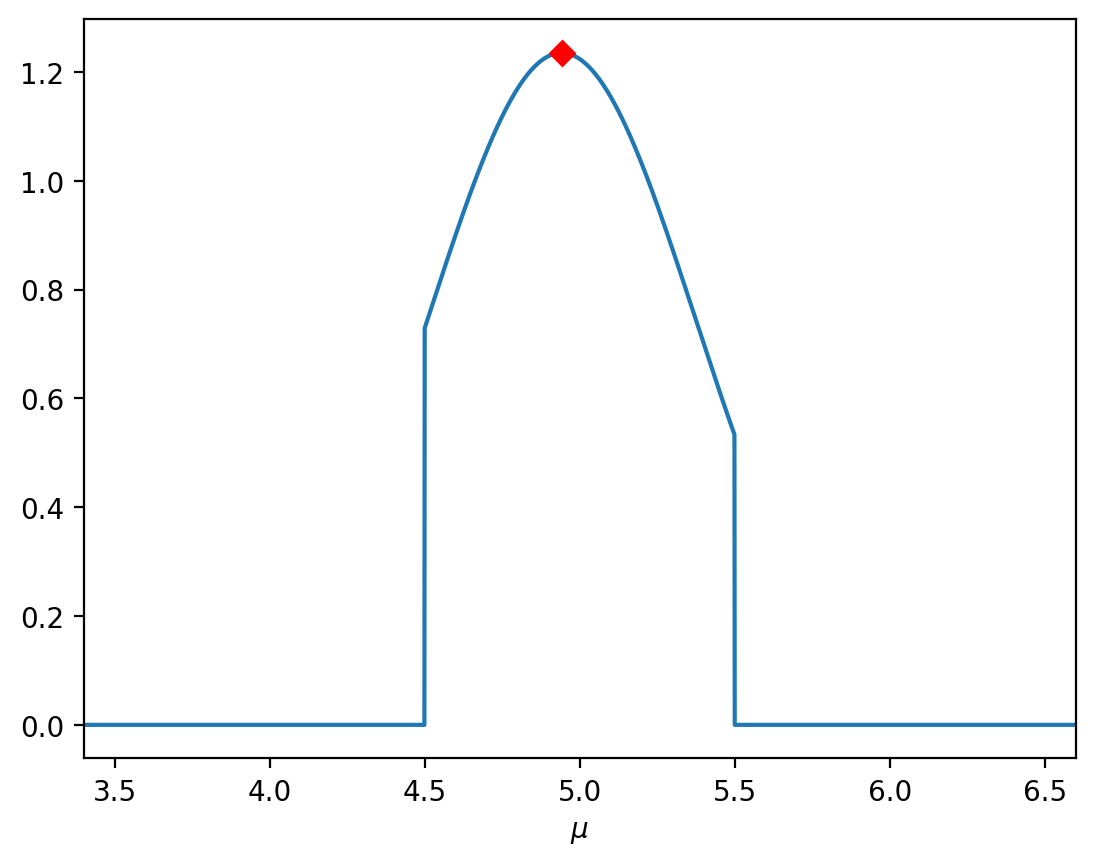

Integral of prior distribution is:  1.0001000100009998
Integral of normalized posterior distribution is:  1.0
Lower bound of cofidence is:  4.843484348434844  Upper bound of cofidence is:  5.104510451045105
From MLE Lower bound is:  4.511874868373254 Upper bound is: 5.372361560477356
MAP:  4.942494249424943
MLE mean:  4.942118214425305


In [81]:
np2, evidence = Bayseian(prior_uniform_2,Likelihood)

SRT: Similarly off in the Bayesian credible regions.

In [82]:
def prior_gaussian(mu,mean=6.1,std=0.25):
    return stat.norm.pdf(mu,loc=mean,scale=std)

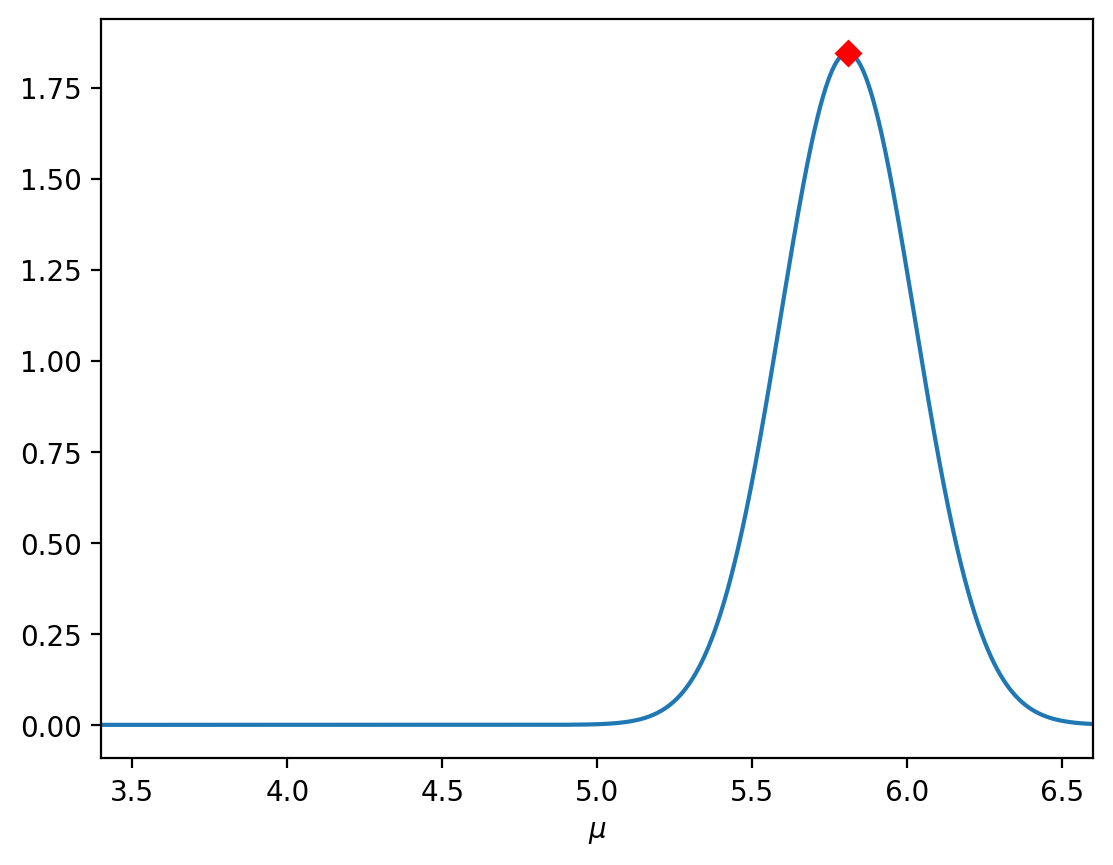

Integral of prior distribution is:  1.0
Integral of normalized posterior distribution is:  1.0000000000000002
Lower bound of cofidence is:  5.720572057205721  Upper bound of cofidence is:  5.896589658965897
From MLE Lower bound is:  4.511874868373254 Upper bound is: 5.372361560477356
MAP:  5.807580758075807
MLE mean:  4.942118214425305


In [83]:
np3, e3 = Bayseian(prior_gaussian,Likelihood)

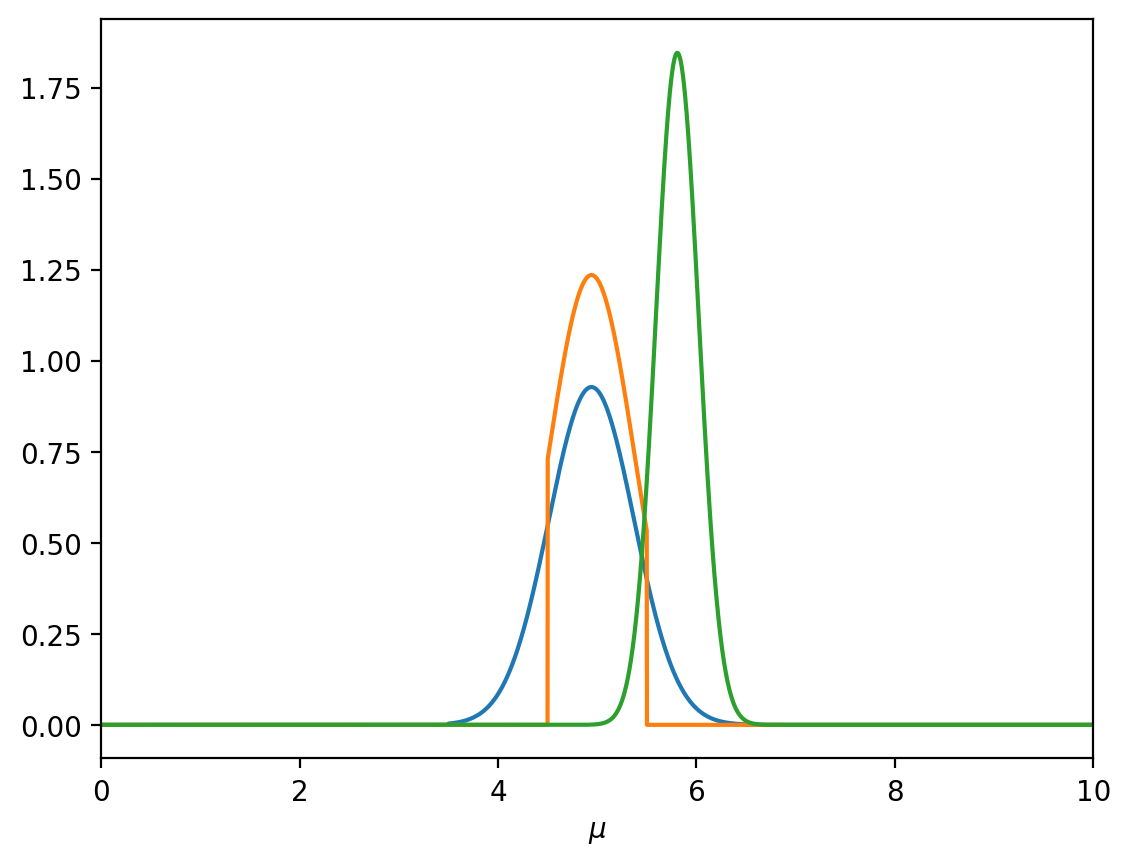

In [84]:
plt.plot(np.linspace(0,10,10000),np1, label="Uniform 1")
plt.plot(np.linspace(0,10,10000),np2, label="Uniform 2")
plt.plot(np.linspace(0,10,10000),np3, label="Gaussian")
plt.xlabel(r"$\mu$")
plt.xlim(0,10)
plt.show()

SRT: Good!

In [85]:
delta_function_evidence = Likelihood(measurements,sample_mean, sigmas)
print("Bayes Factor: ", delta_function_evidence / e1)

Bayes Factor:  2.783267579994427


<font color="blue"> It seems that by knowing the mean and using it in the prior is a slight advantage evidencewise, however, the advantage is only slight and not totally overwhelming </font>

SRT: Very good, Joe.

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

In [86]:
data = np.load("hw4_data_2.npy")

In [87]:
x, y, sigma_y = data

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [88]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stat.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

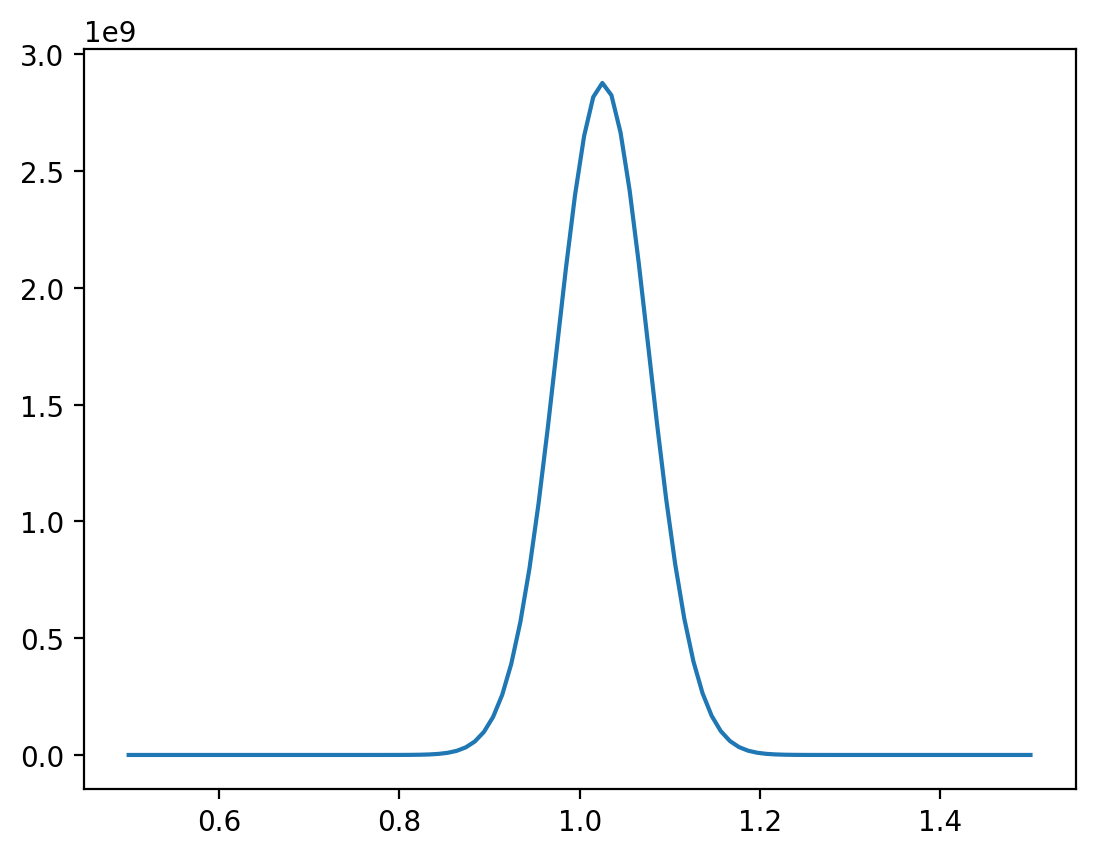

In [89]:
slopes = np.linspace(0.5,1.5,100)
posterior = np.array([np.exp(logL([-0.23,slope],data)) * stat.uniform.pdf(slope,loc=0.5,scale=1) for slope in slopes])
plt.plot(slopes,posterior)
plt.show()

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number! 

In [90]:
evidence = np.trapz(posterior,slopes)
print("Evidence is: ",evidence)

Evidence is:  365684733.16065943


4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

In [91]:
linear = np.linspace(0.5,1.5,100)
quadratic = np.linspace(-1,0.25,100)

posterior_quad = np.array([[np.exp(logL([-0.23,lin,quad],data)) * stat.uniform.pdf(lin,loc=0.5,scale=1) * stat.uniform.pdf(quad,loc=-1,scale=1.25) for lin in linear] for quad in quadratic])

SRT: No plot? -3 points

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

In [92]:
evidence_quad = np.trapz(np.trapz(posterior_quad,linear,axis=0),quadratic,axis=0)
print("Evidence for quad is: ",evidence_quad)

Evidence for quad is:  490433690.61699915


6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in Lecture 9?

In [93]:
factor = evidence / evidence_quad
print("Bayes factor is equal to: ",factor)

Bayes factor is equal to:  0.7456354246393697


<font color="blue"> It seems that the quad version of the model is weighted as better than the lienar. However, there is no penalty using this method of comparison for extra model parameters, so that is the difference between this and BIC </font>

SRT: Correct answer. Well done!

44/50